### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [4]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [6]:
print(arxiv.invoke("Attention is all you need"))

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [7]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [9]:
print(wiki.invoke("Attention is all you need"))

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [11]:
import os 
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [ ]:
from langchain_tavily import TavilySearch
tavily = TavilySearch()

In [ ]:
tavily.invoke("give me the current AI news")

In [34]:
### Combine all the tools in the list 
tools = [arxiv, wiki, tavily]

In [20]:
###Initialize the llm model
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tool = llm.bind_tools(tools)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

response = llm_with_tool.invoke([HumanMessage(content=f"What is the recent AI news")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jkXfokayjdqimaabuwHeKxXv', 'function': {'arguments': '{"query":"AI news","topic":"news","time_range":"month"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1405, 'total_tokens': 1431, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CD7Ob8GIjWih5vrqXNEtOeJ0rv8Bh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e2c7e250-9027-4b68-9101-5386684ba66d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'AI news', 'topic': 'news', 'time_range': 'month'}, 'id': 'call_jkXfokayjdqimaabuwHeKxXv', 'type': 'tool_call'}], usage_metadata=

In [28]:
response.tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'AI news', 'topic': 'news', 'time_range': 'week'},
  'id': 'call_p1ydosuxn7uIPcPEisppBSMd',
  'type': 'tool_call'}]

In [30]:
#State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

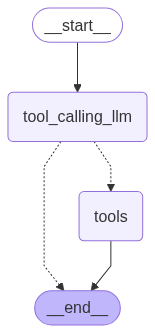

In [37]:
### Entire Chatbot with Langgraph
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from pprint import pprint

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

#Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)

builder.add_edge("tools", END)

graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_M9fl5PVqcXrGBTRu9EuJlDZX)
 Call ID: call_M9fl5PVqcXrGBTRu9EuJlDZX
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [48]:
messages=graph.invoke({"messages":HumanMessage(content="What is time in US now")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is time in US now
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_ksXjuiPec9j5e0TpG4w3Kprj)
 Call ID: call_ksXjuiPec9j5e0TpG4w3Kprj
  Args:
    query: current time in the United States
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "current time in the United States", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://24timezones.com/United-States/time", "title": "Local time in United States right now - 24 Time Zones", "content": "Current local time in United States · Chicago · Houston · San Antonio · Dallas. 4:53 PM. Friday, September 5, 2025. GMT -06:00. MDT · Denver · El Paso ...California·Alabama·Florida·Colorado", "score": 0.7961819, "raw_content": null}, {"url": "https://24timezones.com/us_clock/usa_time.

In [43]:
messages=graph.invoke({"messages":HumanMessage(content="What is Machine Learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is Machine Learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_zNvuYk4dPMHEcWq9whpZ1lJf)
 Call ID: call_zNvuYk4dPMHEcWq9whpZ1lJf
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
